In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
delta = 0.2
nx, ny = 128, 128  
xmax, ymax = delta * nx, delta * ny
TOL = 1e-8

In [10]:
def VB1(y):
    return np.sin(np.pi * y / ymax)

def VB2(x):
    return -np.sin(2 * np.pi * x / xmax)

def VB3(y):
    return np.sin(np.pi * y / ymax)

def VB4(x):
    return np.sin(2 * np.pi * x / xmax)

In [11]:
def inicjalizacja(nx, ny):
    V = np.zeros((nx + 1, ny + 1))
    x = np.linspace(0, xmax, nx + 1)
    y = np.linspace(0, ymax, ny + 1)
    V[:, 0] = VB4(x)  
    V[:, -1] = VB2(x)  
    V[0, :] = VB1(y)  
    V[-1, :] = VB3(y)  
    return V

In [12]:
def relaksacja(V, nx, ny, delta, TOL):
    iterations = 0
    S_prev = 1e10
    V_new = V.copy()
    S_values = []

    while True:
        S = 0.0

        for i in range(1, nx):
            for j in range(1, ny):
                V_new[i, j] = 0.25 * (V[i + 1, j] + V[i - 1, j] + V[i, j + 1] + V[i, j - 1])

        
        for i in range(1, nx):
            for j in range(1, ny):
                grad_x = (V_new[i, j] - V_new[i - 1, j]) / delta
                grad_y = (V_new[i, j] - V_new[i, j - 1]) / delta
                S += 0.5 * delta**2 * (grad_x**2 + grad_y**2)



        S_values.append(S)

        
        if abs(S - S_prev) / S_prev < TOL:
            break
        S_prev = S
        V = V_new
        iterations += 1

    return V_new, S_values



def zageszczenie_siatki(V, nx, ny):
    zageszczone_V = np.zeros((2 * nx + 1, 2 * ny + 1))
    for i in range(nx + 1):
        for j in range(ny + 1):
            zageszczone_V[2 * i, 2 * j] = V[i, j]


    for i in range(nx):
        for j in range(ny):
            zageszczone_V[2 * i + 1, 2 * j + 1] = 0.25 * (
                V[i, j] + V[i + 1, j] + V[i, j + 1] + V[i + 1, j + 1]
            )
            zageszczone_V[2 * i + 1, 2 * j] = 0.5 * (V[i, j] + V[i + 1, j])
            zageszczone_V[2 * i, 2 * j + 1] = 0.5 * (V[i, j] + V[i, j + 1])

    for i in range(nx):
        zageszczone_V[2 * i + 1, -1] = 0.5 * (V[i, -1] + V[i + 1, -1])

    for j in range(ny):
        zageszczone_V[-1, 2 * j + 1] = 0.5 * (V[-1, j] + V[-1, j + 1])


    return zageszczone_V

def multigrid_poisson():
    k_values = [16, 8, 4, 2, 1]
    results = {} 
    functional_history = {}

    
    V = inicjalizacja(int(nx / k_values[0]), int(ny / k_values[0]))
    for k in k_values:
        grid_size = int(nx / k)
        V, S_values = relaksacja(V, grid_size, grid_size, delta, TOL)
        results[k] = V
        functional_history[k] = S_values

        
        if k > 1:
            V = zageszczenie_siatki(V, grid_size, grid_size)

    return results, functional_history

In [13]:
def plot_results(results, functional_history):
    fig, axes = plt.subplots(2, 3, figsize=(12, 12))

    for idx, (k, V) in enumerate(results.items()):
        row, col = divmod(idx, 3)
        im = axes[row, col].imshow(V.transpose(), cmap="seismic", origin="lower", interpolation="none", vmin=-1, vmax=1)
        axes[row, col].set_title(f"k={k}")
        axes[row, col].set_xlabel("x")
        axes[row, col].set_ylabel("y")
        fig.colorbar(im, ax=axes[row, col])

    ax = axes[1, 2]
    for k, S_values in functional_history.items():
        ax.plot(range(len(S_values)), S_values, label=f"k={k}")
    ax.set_title("S(it)")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("S")
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()


In [14]:
results, functional_history = multigrid_poisson()

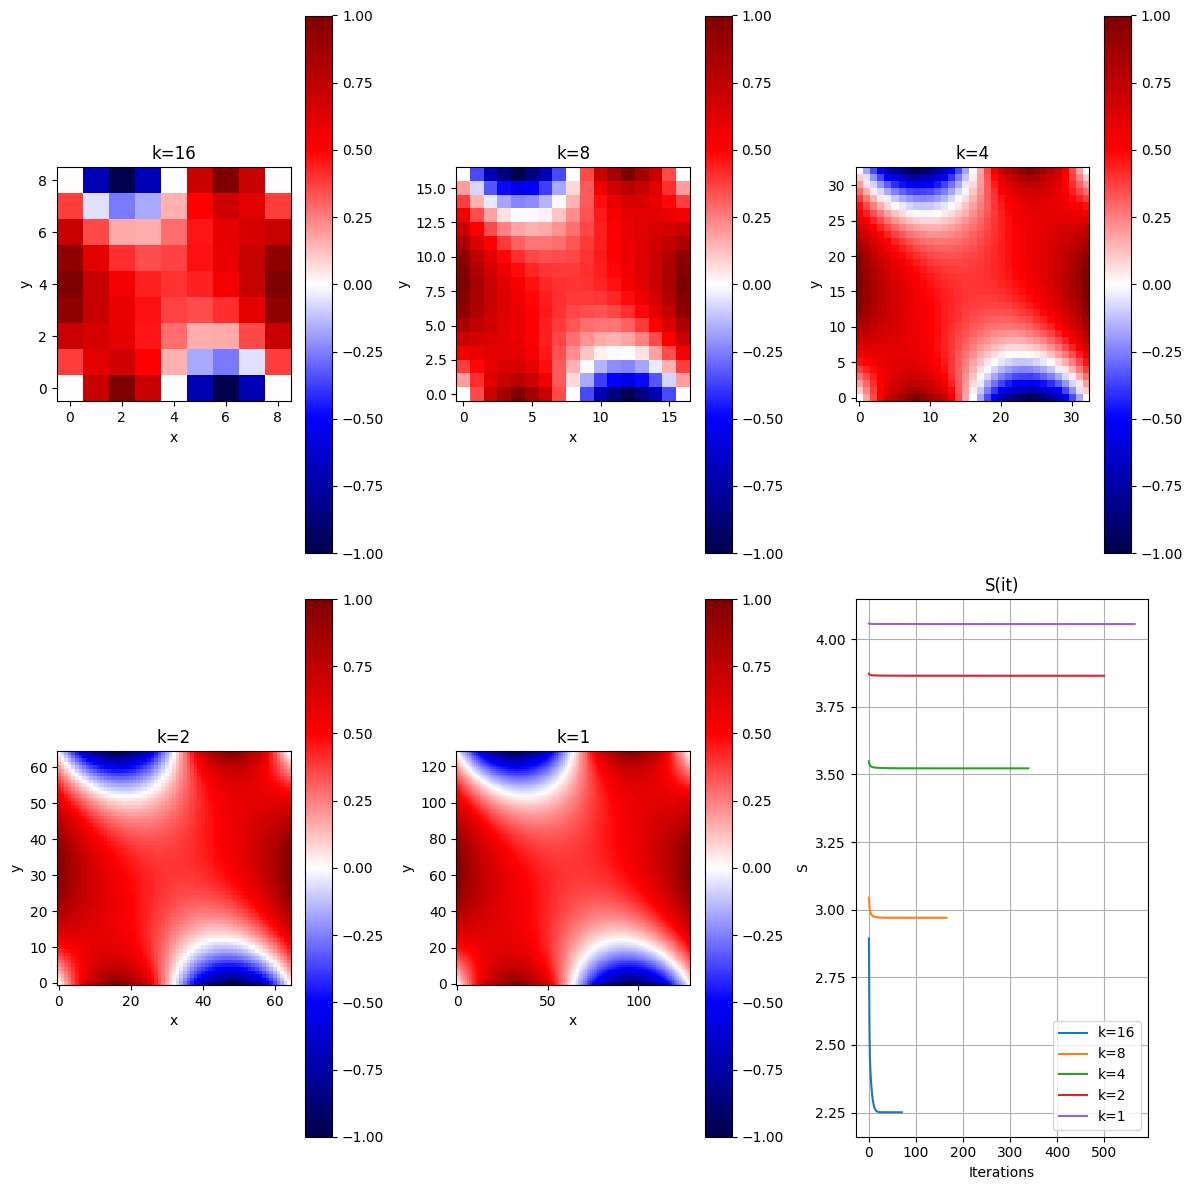

In [15]:
plot_results(results, functional_history)